## Import libraries

In [17]:
# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as msno
from plotnine import *
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
from sklearn.impute import KNNImputer

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 
from sklearn.compose import make_column_selector

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag # for bagging
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# feature selection
from sklearn.feature_selection import SelectKBest, f_regression

## Import and clean training and test data

In [18]:
# Data on Housing Prices in DC
test_data = pd.read_csv("../test_data.csv")
train_data =  pd.read_csv("../train_data.csv")

In [19]:
# see shape of training data
train_data.shape

(43590, 39)

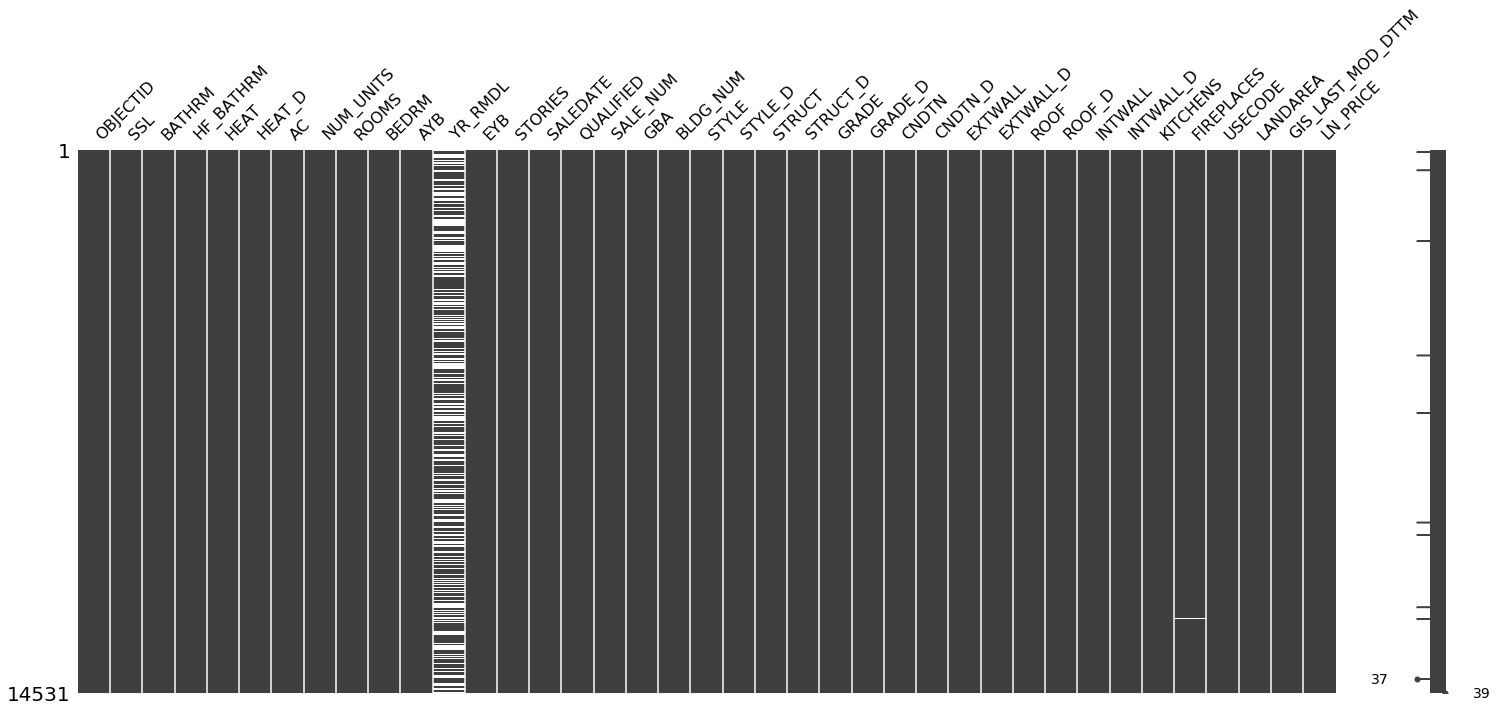

In [20]:
msno.matrix(test_data)

I want to go ahead and isolate the variables that can potentially be used as predictors. This means dropping things like arbitrary codes, and keeping continuous numeric data. 

In [21]:
# select all numeric columns other than object ID
train_data = train_data.select_dtypes(include=np.number).drop(["OBJECTID","USECODE", "YR_RMDL"],1)
test_data = test_data.select_dtypes(include=np.number).drop(["OBJECTID","USECODE", "YR_RMDL"],1)

In [22]:
# check that i want to use all of them
list(train_data)

['BATHRM',
 'HF_BATHRM',
 'HEAT',
 'NUM_UNITS',
 'ROOMS',
 'BEDRM',
 'AYB',
 'EYB',
 'STORIES',
 'SALE_NUM',
 'GBA',
 'BLDG_NUM',
 'STYLE',
 'STRUCT',
 'GRADE',
 'CNDTN',
 'EXTWALL',
 'ROOF',
 'INTWALL',
 'KITCHENS',
 'FIREPLACES',
 'LANDAREA',
 'LN_PRICE']

In [23]:
# take a look at data
train_data.describe()

,BATHRM,HF_BATHRM,HEAT,NUM_UNITS,ROOMS,BEDRM,AYB,EYB,STORIES,SALE_NUM,...,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,LANDAREA,LN_PRICE
count,43589.000000,43588.000000,43589.000000,43589.000000,43579.000000,43586.000000,43586.000000,43590.000000,43561.000000,43590.000000,...,43589.000000,43589.000000,43589.000000,43589.000000,43589.000000,43589.000000,43588.000000,43589.000000,43590.000000,43590.000000
mean,2.203331,0.649697,6.853954,1.220675,7.424815,3.428073,1931.199422,1969.804313,2.120653,1.857880,...,5.076579,4.297116,3.706348,13.467756,3.960839,6.302049,1.250551,0.639014,3175.001078,12.927904
std,1.068895,0.608786,5.151037,0.624555,2.334643,1.163447,86.229606,16.926513,4.184655,1.453624,...,2.819329,1.373435,0.746981,4.045380,3.334032,2.098208,0.669050,0.905193,3200.666743,0.865822
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1900.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,1.000000,6.000000,3.000000,1913.000000,1957.000000,2.000000,1.000000,...,1.000000,3.000000,3.000000,14.000000,1.000000,6.000000,1.000000,0.000000,1520.000000,12.388394
50%,2.000000,1.000000,7.000000,1.000000,7.000000,3.000000,1929.000000,1967.000000,2.000000,1.000000,...,7.000000,4.000000,4.000000,14.000000,2.000000,6.000000,1.000000,0.000000,2212.000000,12.994530
75%,3.000000,1.000000,13.000000,1.000000,8.000000,4.000000,1947.000000,1975.000000,2.000000,3.000000,...,7.000000,5.000000,4.000000,14.000000,6.000000,6.000000,1.000000,1.000000,4000.000000,13.527828
max,24.000000,11.000000,13.000000,6.000000,36.000000,54.000000,2018.000000,2018.000000,826.000000,15.000000,...,8.000000,12.000000,6.000000,24.000000,15.000000,11.000000,44.000000,13.000000,187301.000000,17.038378


There's definitely red flags here. 54 bedrooms when the mean is 7, 826 stories (not even possible), 44 kitchens when the mean is 1 kitchen. I am not sure how to deal with outliers yet.

In [24]:
# How many missing values do we have?
train_data.isnull().sum()

BATHRM         1
HF_BATHRM      2
HEAT           1
NUM_UNITS      1
ROOMS         11
BEDRM          4
AYB            4
EYB            0
STORIES       29
SALE_NUM       0
GBA            0
BLDG_NUM       0
STYLE          1
STRUCT         1
GRADE          1
CNDTN          1
EXTWALL        1
ROOF           1
INTWALL        1
KITCHENS       2
FIREPLACES     1
LANDAREA       0
LN_PRICE       0
dtype: int64

In [25]:
# look at the null values for one column
train_data[train_data['ROOMS'].isnull()]

,BATHRM,HF_BATHRM,HEAT,NUM_UNITS,ROOMS,BEDRM,AYB,EYB,STORIES,SALE_NUM,...,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,LANDAREA,LN_PRICE
1296,2.0,0.0,1.0,2.0,NaN,5.0,1900.0,1964,NaN,1,...,7.0,3.0,4.0,14.0,0.0,3.0,2.0,2.0,1890,13.091904
10183,2.0,0.0,1.0,2.0,NaN,5.0,1909.0,1967,3.0,1,...,7.0,4.0,3.0,14.0,2.0,6.0,2.0,0.0,2520,12.055610
11823,4.0,0.0,13.0,4.0,NaN,4.0,1943.0,1954,2.0,1,...,2.0,3.0,3.0,14.0,2.0,6.0,4.0,0.0,3640,12.278393
13415,3.0,0.0,1.0,3.0,NaN,6.0,1885.0,1969,NaN,3,...,6.0,5.0,4.0,14.0,2.0,6.0,3.0,0.0,1330,13.487006
14217,3.0,0.0,13.0,3.0,NaN,3.0,1905.0,1957,3.0,1,...,7.0,4.0,3.0,14.0,2.0,6.0,3.0,1.0,4362,12.611538
19370,6.0,0.0,1.0,4.0,NaN,10.0,1953.0,1962,2.0,1,...,2.0,3.0,3.0,14.0,2.0,2.0,4.0,0.0,7213,11.407565
25181,3.0,1.0,8.0,1.0,NaN,3.0,2011.0,2014,3.0,1,...,7.0,6.0,6.0,22.0,1.0,11.0,1.0,0.0,547,13.198166
26436,2.0,0.0,6.0,0.0,NaN,NaN,1950.0,1950,2.0,1,...,1.0,0.0,0.0,14.0,0.0,6.0,1.0,2.0,5200,13.997832
30325,3.0,0.0,1.0,1.0,NaN,3.0,1960.0,1971,1.0,3,...,1.0,4.0,3.0,14.0,1.0,8.0,1.0,0.0,9547,13.081541
31005,NaN,NaN,NaN,NaN,NaN,NaN,2002.0,2002,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3167,13.458836


In [26]:
# drop missing values from both datasets
#train_data = train_data.dropna().reset_index(drop=True)
#test_data = test_data.dropna().reset_index(drop=True)

When it comes to handling missing values, I'm honestly not sure what the right choice is here. I could impute them with the mean value of that column, but then I'd be training my model on incorrect information. I could just drop them, losing some data but probably not that much in the grand scheme of things. I also found an imputer that implements a KNN approach to replace missing values.

I ran one version dropping all of them and found using GridSearchCV that my best MSE was 0.378 with KNN = 50. Now I'll try imputing with the missing values with the KNNImputer.

Update: I got the same results..? MSE of 0.378 with KNN = 50. Either I did the imputer wrong or dropping the values somehow had the same exact effect on our predictions.

In [27]:
# define imputer
imputer = KNNImputer(weights="uniform")

In [28]:
col_names = list(train_data)

In [29]:
# fit imputer to test and training data
train_data = imputer.fit_transform(train_data)
test_data = imputer.fit_transform(test_data)

In [30]:
# put them back into dataframes
train_data = pd.DataFrame(train_data,columns=col_names)
test_data = pd.DataFrame(test_data,columns=col_names)

In [31]:
#no more nulls
train_data.isnull().sum()

BATHRM        0
HF_BATHRM     0
HEAT          0
NUM_UNITS     0
ROOMS         0
BEDRM         0
AYB           0
EYB           0
STORIES       0
SALE_NUM      0
GBA           0
BLDG_NUM      0
STYLE         0
STRUCT        0
GRADE         0
CNDTN         0
EXTWALL       0
ROOF          0
INTWALL       0
KITCHENS      0
FIREPLACES    0
LANDAREA      0
LN_PRICE      0
dtype: int64

In [32]:
# make my x and y datasets for training
train_y = train_data['LN_PRICE']
train_X = train_data.drop('LN_PRICE',1)

In [33]:
# make my y dataset for testing
test_y = test_data['LN_PRICE']
test_X = test_data.drop('LN_PRICE',1)

## Choose features to use

Here I will be trying the **SelectKBest** feature selection method in SKlearn. I'm not 100% sure how to use it, but I will use it to find out what the best *five* predictors are and then move forward with those.

In [34]:
# make the selector 
selector  = SelectKBest(score_func=f_regression, k=5)

In [35]:
# fit selector to data
train_X_new = selector.fit_transform(train_X, train_y)

In [36]:
# make the features it chose into columns
cols = selector.get_support(indices = True)

In [37]:
# create new dataframe
train_X = train_X.iloc[:,cols]
test_X = test_X.iloc[:,cols]

In [38]:
train_X.head()

,BATHRM,GBA,GRADE,CNDTN,FIREPLACES
0,3.0,1260.0,5.0,5.0,0.0
1,2.0,1426.0,6.0,5.0,1.0
2,2.0,2270.0,6.0,3.0,1.0
3,1.0,1278.0,3.0,3.0,0.0
4,2.0,2936.0,5.0,3.0,0.0


It looks like the features it selected are bathroom, grade, gross building area, condition and fireplaces. Let's take a look at the correlation between these variables and Price using another method, a basic correlation matrix. 

In [39]:
# plot corelation between every possible predictor and the price 
train_data[train_data.columns[0:23]].corr()['LN_PRICE'][:-1]

BATHRM        0.480822
HF_BATHRM     0.286248
HEAT         -0.066568
NUM_UNITS    -0.012938
ROOMS         0.277185
BEDRM         0.317811
AYB          -0.018326
EYB           0.346524
STORIES       0.033389
SALE_NUM      0.283185
GBA           0.465223
BLDG_NUM      0.027737
STYLE         0.220332
STRUCT       -0.134196
GRADE         0.577984
CNDTN         0.407633
EXTWALL       0.032230
ROOF          0.244575
INTWALL       0.051151
KITCHENS      0.026458
FIREPLACES    0.456304
LANDAREA      0.211972
Name: LN_PRICE, dtype: float64

The variables it chose for us do have the highest linear correlations with price, so that seems like a sign that we are headed in the right direction. Now we will take a look at these correlations visually as well.

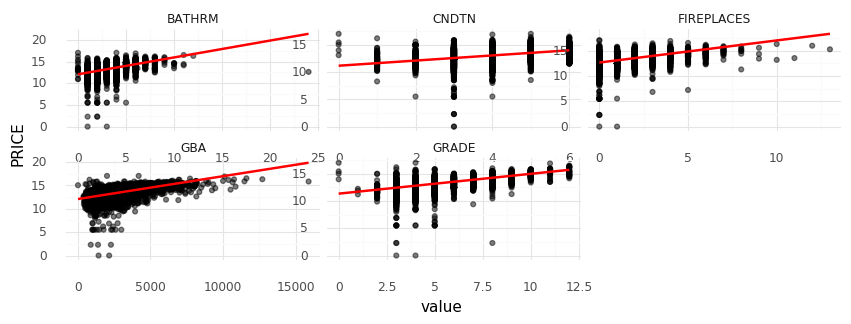

<ggplot: (8776614907645)>

In [40]:
# make a copy of the training features and outcome data
E = train_X.copy()
E['PRICE'] = train_y

(
    ggplot(E.melt(id_vars=["PRICE"]),
           aes(x="value",y="PRICE"))+
    geom_point(alpha=.5) +
    facet_wrap("variable",scales="free") +
    geom_smooth(method="lm",se=False,color="red") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
)

## Build modeling pipeline with relevant tuning parameters and fit to data

In [41]:
# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), make_column_selector(dtype_exclude=None))])

# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])

# (4) Specify which models we're looking at and the tuning parameters we will try out 
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30,40,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]

# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)


In [42]:
# Now we can finally fit our training data to the model itself
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pre_process',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         MinMaxScaler(copy=True,
                                                                                      feature_range=(0,
                                                                                                     1)),
                                                                         <sklearn.compose._column_transfo

In [43]:
# What is the best score?
search.best_score_ # Mean out-of-sample (CV) error

-0.37870033282671167

In [44]:
# Which is the best model?
search.best_params_

{'model': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform'),
 'model__n_neighbors': 50}

## Evaluate model performance on test data

Now let's see how this method works on our actual test data.

In [45]:
# Predict() method will use the best model out of the scan
pred_y = search.predict(test_X)

In [46]:
m.mean_squared_error(test_y,pred_y)

0.3701345810945492

In [47]:
m.r2_score(test_y,pred_y)

0.49947108628123593

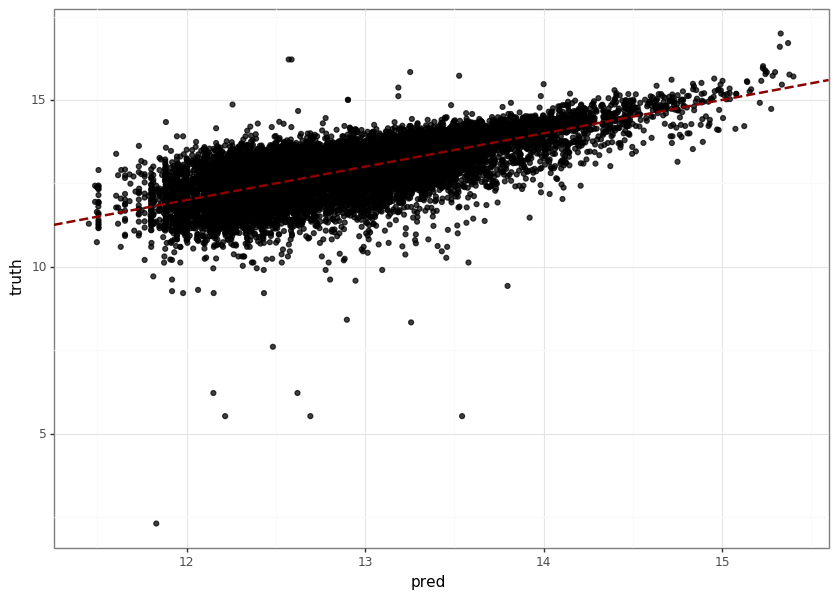

<ggplot: (8776587543897)>

In [48]:
# see how in the pipeline we preprocessed X so it is fixed beforehand and we can make sense of the predictions 
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

## Conclusion

The MSE for the model selected by GridSearchCV (KNN with K = 50) was 0.379, which is okay. When we tested this on our test data, it performed very similarly with a MSE of 0.370 though a tiny bit better. The R squared score was 0.5 between our predicted and true values of logged house price, which means that about half of the variation of our predicted values can be explained by our model.

Remaining questions: What happened to the predictions < 12?? 